In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
slotcodes = {
    0 : 'QB', 1 : 'QB',
    2 : 'RB', 3 : 'RB',
    4 : 'WR', 5 : 'WR',
    6 : 'TE', 7 : 'TE',
    16: 'D/ST',
    17: 'K',
    20: 'Bench',
    21: 'IR',
    23: 'Flex'
}

In [3]:
swid = ""
espn = ""

In [4]:
def get_matchups(league_id, season, week, swid='', espn=''):
    ''' 
    Pull full JSON of matchup data from ESPN API for a particular week.
    '''
    
    url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/' + \
      str(season) + '/segments/0/leagues/' + str(league_id)

    r = requests.get(url + '?view=mMatchup&view=mMatchupScore',
                     params={'scoringPeriodId': week, 'matchupPeriodId': week},
                     cookies={"SWID": swid, "espn_s2": espn})
    return r.json()

def get_slates(json):
    '''
    Constructs week team slates with slotted position, 
    position, and points (actual and ESPN projected),
    given full matchup info (`get_matchups`)
    '''
    
    slates = {}

    for team in d['teams']:
        slate = []
        for p in team['roster']['entries']:
            # get name
            name  = p['playerPoolEntry']['player']['fullName']

            # get actual lineup slot
            slotid = p['lineupSlotId']
            slot = slotcodes[slotid]

            # get projected and actual scores
            act, proj = 0, 0
            for stat in p['playerPoolEntry']['player']['stats']:
                if stat['scoringPeriodId'] != week:
                    continue
                if stat['statSourceId'] == 0:
                    act = stat['appliedTotal']
                elif stat['statSourceId'] == 1:
                    proj = stat['appliedTotal']
                else:
                    print('Error')

            # get type of player
            pos = 'Unk'
            ess = p['playerPoolEntry']['player']['eligibleSlots']
            if 0 in ess: pos = 'QB'
            elif 2 in ess: pos = 'RB'
            elif 4 in ess: pos = 'WR'
            elif 6 in ess: pos = 'TE'
            elif 16 in ess: pos = 'D/ST'
            elif 17 in ess: pos = 'K'

            slate.append([name, slotid, slot, pos, act, proj])

        slate = pd.DataFrame(slate, columns=['Name', 'SlotID', 'Slot', 'Pos', 'Actual', 'Proj'])
        slates[team['id']] = slate

    return slates

def compute_pts(slates, posns, struc):
    '''
    Given slates (`get_slates`), compute total roster pts:
    actual, optimal, and using ESPN projections
    
    Parameters
    --------------
    slates : `dict` of `DataFrames`
        (from `get_slates`)
    posns : `list`
        roster positions, e.g. ['QB','RB', 'WR', 'TE']
    struc : `list`
        slots per position, e.g. [1,2,2,1]
        
    * This is not flexible enough to handle "weird" leagues
    like 6 Flex slots with constraints on # total RB/WR
    
    Returns
    --------------
    `dict` of `dict`s with actual, ESPN, optimal points
    '''
    
    data = {}
    for tmid, slate in slates.items():
        pts = {'opts': 0, 'epts': 0, 'apts': 0}

        # ACTUAL STARTERS
        pts['apts'] = slate.query('Slot not in ["Bench", "IR"]').filter(['Actual']).sum().values[0]

        # OPTIMAL and ESPNPROJ STARTERS
        for method, cat in [('Actual', 'opts'), ('Proj', 'epts')]:
            actflex = -100  # actual pts scored by flex
            proflex = -100  # "proj" pts scored by flex
            for pos, num in zip(posns, struc):
                # actual points, sorted by either actual or proj outcome
                t = slate.query('Pos == @pos').sort_values(by=method, ascending=False).filter(['Actual']).values[:,0]

                # projected points, sorted by either actual or proj outcome
                t2 = slate.query('Pos == @pos').sort_values(by=method, ascending=False).filter(['Proj']).values[:,0]

                # sum up points
                pts[cat] += t[:num].sum()

                # set the next best as flex
                if pos in ['RB', 'WR', 'TE'] and len(t) > num:
                    fn = t[num] if method=='Actual' else t2[num]
                    if fn > proflex:
                        actflex = t[num]
                        proflex = fn

            pts[cat] += actflex
        
        data[tmid] = pts
        
    return data

def get_teamnames(league_id, season, week, swid='', espn=''):
    url = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/' + \
      str(season) + '/segments/0/leagues/' + str(league_id)
    
    r = requests.get(url + '?view=mTeam',
                  params={'scoringPeriodId': week},
                  cookies={"SWID": swid, "espn_s2": espn})
    d = r.json()
    
    tm_names = {tm['id']: tm['location'].strip() + ' ' + tm['nickname'].strip() \
                for tm in d['teams']}
    
    return tm_names

In [5]:
def plot_week(d, data, week, tm_names, nummatchups=5, 
              minx=70, maxx=200, legend=4):
    fig, ax = plt.subplots(1,1, figsize=(12,8))

    # hardcoded plot adjustments
    dif, offset = 5, 2
    
    # for y-axis tick labels
    tmlist, tmticks, tmbold = [], [], []

    cury = 0
    for g in d['schedule'][:nummatchups]:
        aid, anm = -1, ''
        hid, hnm = -1, ''
        try:
            aid = g['away']['teamId']
            anm = tm_names[aid]
            hid = g['home']['teamId']
            hnm = tm_names[hid]
        except:
            continue

        tmlist.append(anm)
        tmlist.append(hnm)

        if data[aid]['apts'] > data[hid]['apts']:
            tmbold.extend([1,0])
        else:
            tmbold.extend([0,1])

        for pts in [data[aid], data[hid]]:
            h = 1 if (pts['opts']-offset) > pts['apts'] else 0
            tmticks.append(cury)
            ax.plot([minx, maxx], [cury, cury], 'k--', linewidth=1, alpha=0.1)
            ax.plot([pts['apts'], pts['opts']-offset*h], [cury, cury], 'k-')
            ax.scatter(pts['epts'], cury, c='w', s=200, marker='o', edgecolor='g')
            ax.scatter(pts['apts'], cury, c='k', s=100)

            # if optimal==actual, need to put blue inside black
            if pts['opts'] == pts['apts']:
                ax.scatter(pts['opts'], cury, c='w', s=25)
                ax.scatter(pts['opts'], cury, c='b', s=25, alpha=0.2)
            else:
                ax.scatter(pts['opts'], cury, c='b', s=100, alpha=0.2)

            cury += dif

        cury += 2*dif

    # setting y-axis
    ax.set(yticks=tmticks,
           yticklabels=tmlist)
    for k, tick in enumerate(ax.yaxis.get_major_ticks()):
        if tmbold[k] == 1:
            tick.label1.set_fontweight('bold')

    # legend stuff
    ax.scatter([],[], c='k', s=100, label='Actual')
    ax.scatter([],[], c='w', s=200, marker='o', edgecolor='g', label='ESPN')
    ax.scatter([],[], c='b', s=100, alpha=0.2, label='Best Possible')
    ax.legend(loc=legend, borderaxespad=2, borderpad=1, labelspacing=1.5, 
              shadow=True, fontsize=12)

    ax.set(title='Week %d' % week)

    return ax

## current season

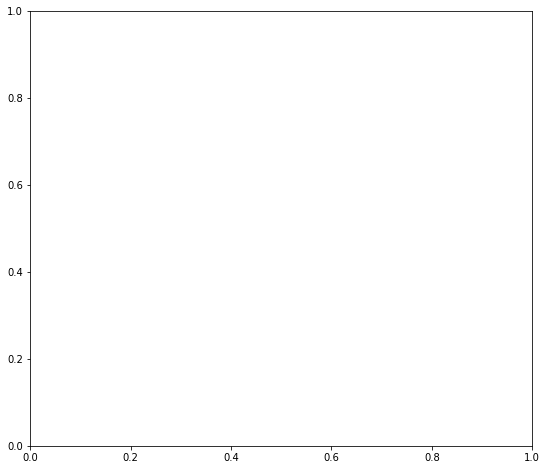

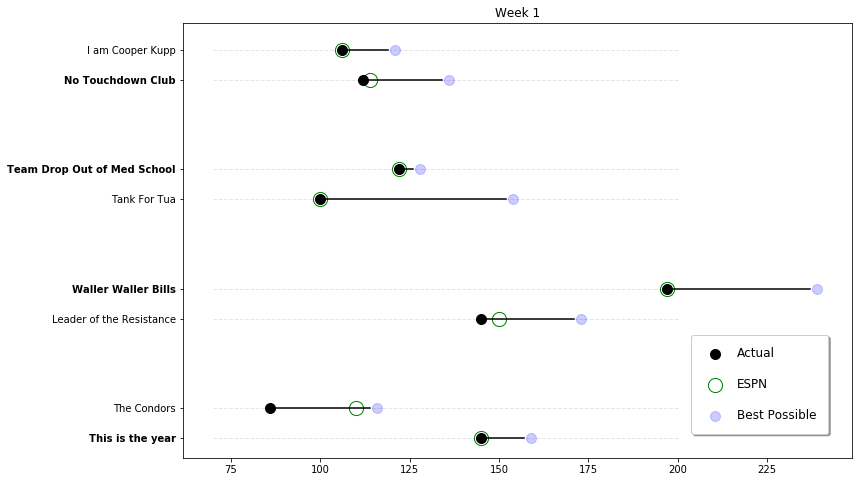

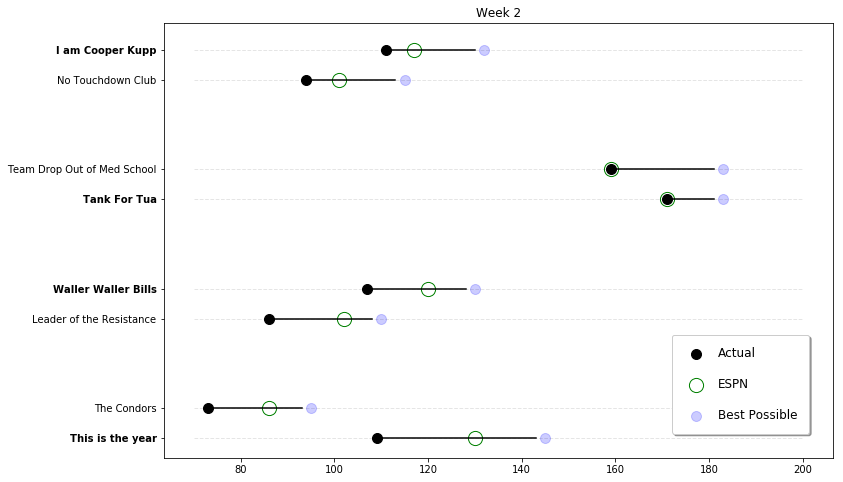

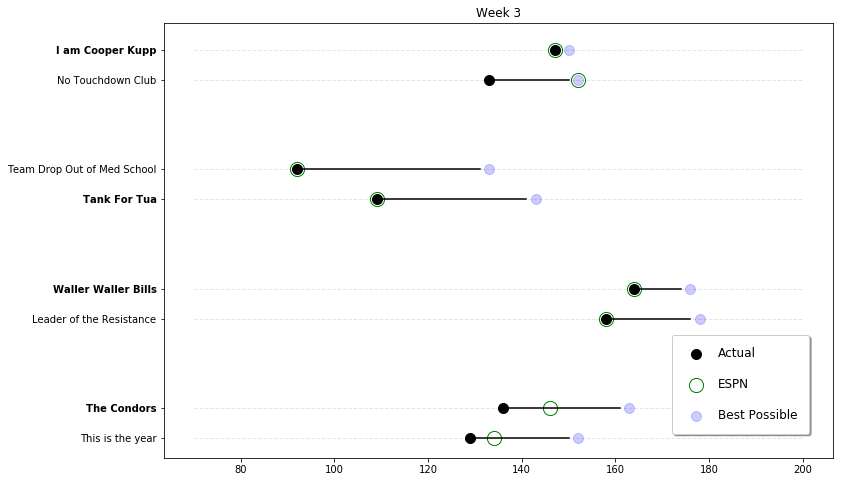

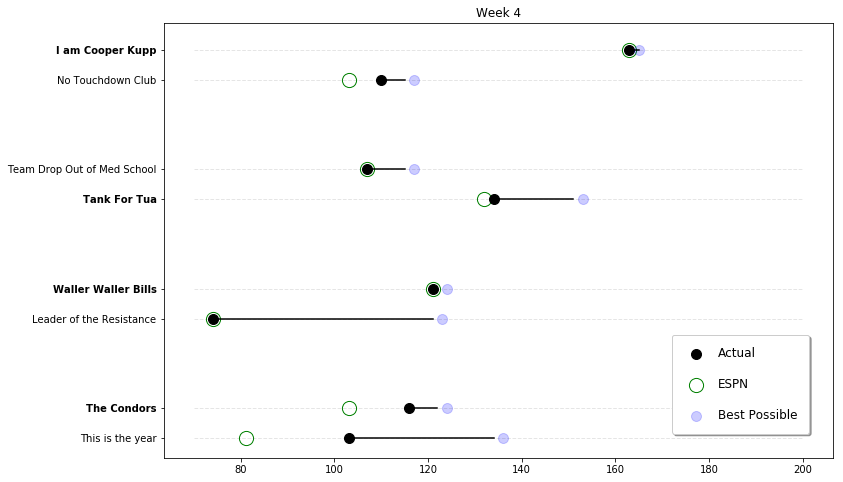

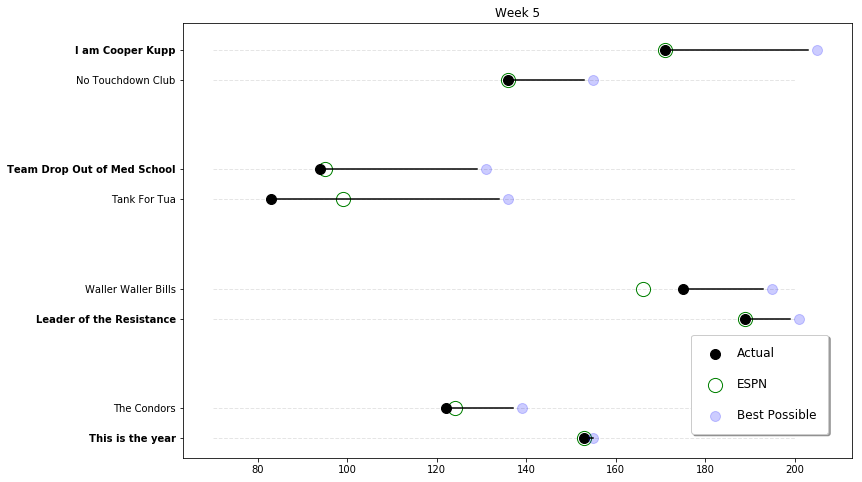

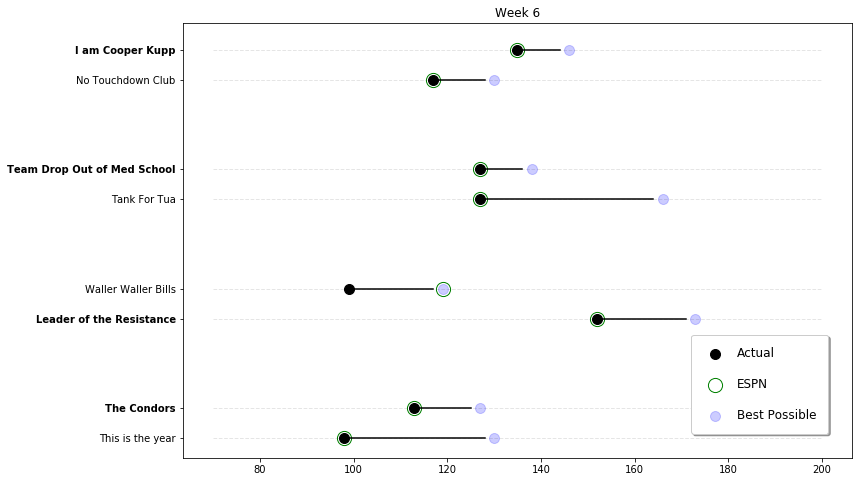

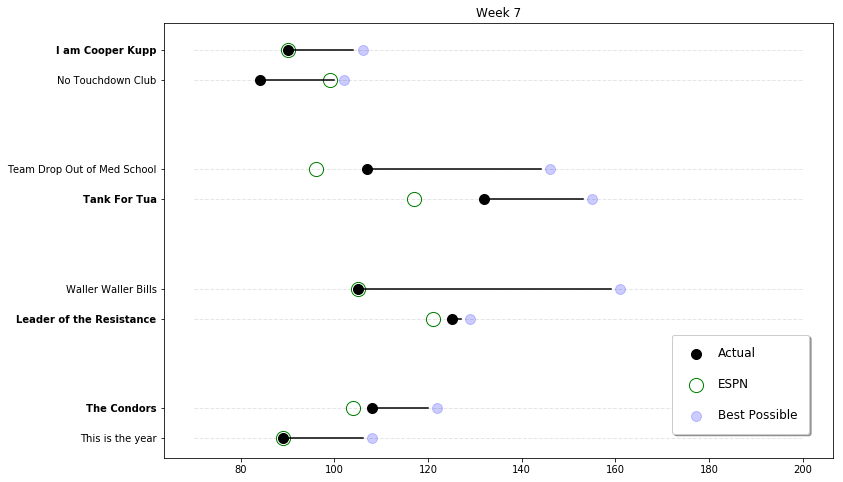

In [37]:
league_id = 123123

season = 2019
for week in range(1,8):
    posns = ['QB', 'RB', 'WR', 'Flex', 'TE', 'D/ST', 'K']
    struc = [1,2,2,1,1,1,1]

    d      = get_matchups(league_id, season, week, swid=swid, espn=espn)
    slates = get_slates(d)
    wdata  = compute_pts(slates, posns, struc)
    tms    = get_teamnames(league_id, season, week, swid=swid, espn=espn)

    ax = plot_week(d, wdata, week, tms, nummatchups=4)
    plt.show()

## last season (multiple weeks)

In [38]:
season = 2018

data = {}
slates = {}
ds = {}
print('Week:', end=' ')
wks = range(1,17)
for week in wks:
    print(week, end=' ')
    d      = get_matchups(league_id, season, week, swid=swid, espn=espn)
    wslate = get_slates(d)
    wdata  = compute_pts(wslate, posns, struc)
    data[week] = wdata
    slates[week] = wslate
    ds[week] = d
tm_names = get_teamnames(league_id, season, 1, swid=swid, espn=espn)

Week: 1 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


2 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


3 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


4 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


5 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


6 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


7 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


8 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


9 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


10 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


11 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


12 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


13 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


14 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


15 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


16 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [30]:
# get league average diff
adiffs = []
for wk in wks:
    for tmid, pts in data[wk].items():
        adiffs.append(pts['apts']-pts['opts'])
avgdiffs = sum(adiffs) / len(adiffs)
avgdiffs

-22.321428571428573

In [31]:
# get league average optimal points
allopts = []
for wk in wks:
    for tmid, pts in data[wk].items():
        allopts.append(pts['opts'])
avgopts = sum(allopts) / len(allopts)
avgopts

144.64285714285714

In [32]:
tmid = 2
tmnm = tm_names[tmid]
nummatchups = 5

fig, ax = plt.subplots(1,1, figsize=(9,8))

# figure out wins
# this is hacky
wins = [0 for _ in wks]
for g in ds[1]['schedule']:
    wk = int(list(g['away']['pointsByScoringPeriod'].keys())[0])
    if wk > 14:
        continue
        
    aid, hid = g['away']['teamId'], g['home']['teamId']
    apt, hpt = g['away']['totalPoints'], g['home']['totalPoints']
    if aid == tmid:
        if apt > hpt:
            wins[wk-1] = 1
    elif hid == tmid:
        if hpt > apt:
            wins[wk-1] = 1

apts = [data[wk][tmid]['apts'] for wk in wks]
epts = [data[wk][tmid]['epts'] for wk in wks]
opts = [data[wk][tmid]['opts'] for wk in wks]
diff = [a-o for o,a in zip(opts,apts)]

clist = sns.color_palette('Blues', len(wks))

minx, maxx = min(diff)-10, 5
miny, maxy = min(opts)-10, max(opts)+20

ax.plot([0,0], [miny+5, maxy-10], 'k-', alpha=0.2)
ax.plot([avgdiffs, avgdiffs], [miny+5, maxy-10], 'k--', alpha=0.2)
ax.plot([minx+10, -2], [avgopts, avgopts], 'k--', alpha=0.2)
ax.text(minx+15, avgopts-4, 'LEAGUE AVERAGES', {'color': 'black', 'fontstyle': 'italic'},
        alpha=0.5)

for wk in wks:
    ax.scatter(diff[wk-1], opts[wk-1], 
               marker='o' if wins[wk-1]==1 else 'x',
               s=200, c=clist[wk-1], edgecolors='k',
               label=wk)
    
ax.legend(bbox_to_anchor=(1.15, 0.8), frameon=False,
          title='Week')

# this is really hacky
ax.arrow(maxx-30,maxy-5, -(maxx-20),0,
         head_width=5, head_length=2, facecolor='k', edgecolor='k', alpha=0.2)
ax.text(maxx-27,maxy-8, 'better starters', {'color': 'black', 'fontstyle': 'italic'}, alpha=0.5)
ax.arrow(minx+5,miny+30, 0, (maxy-miny) / 2,
         head_width=2, head_length=4, facecolor='k', edgecolor='k', alpha=0.2)
ax.text(minx+5.5,miny+70, 'better roster', {'color': 'black', 'fontstyle': 'italic'},
        rotation=90, alpha=0.5)

ax.set(xlim=[minx,maxx], ylim=[miny,maxy],
       xticks=range(int(minx/10)*10-10,9,10),
       xlabel='Actual points back from Best Possible',
       ylabel='Best Possible points',
       title='%s (%d)' % (tmnm, season))

plt.show()

KeyError: 'pointsByScoringPeriod'

In [27]:
z = []
for tmid, tmname in tm_names.items():
    opts  = [data[wk][tmid]['opts'] for wk in wks]
    diffs = [data[wk][tmid]['apts']-data[wk][tmid]['opts'] for wk in wks]
    opts = sum(opts) / len(opts)
    diffs = sum(diffs) / len(diffs)
    z.append({'id': tmid, 'name': tmname, 'opt': opts, 'diff': diffs})

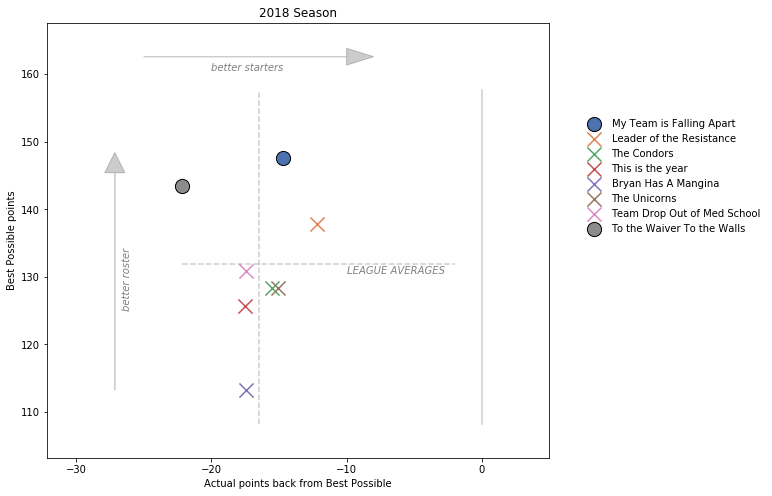

In [28]:
fig, ax = plt.subplots(1,1, figsize=(9,8))

playoffs = [1, 9, 13, 14]

clist = sns.color_palette('deep', len(tm_names))

minx, maxx = min([zz['diff'] for zz in z])-10, 5
miny, maxy = min([zz['opt'] for zz in z])-10, max([zz['opt'] for zz in z])+20

ax.plot([0,0], [miny+5, maxy-10], 'k-', alpha=0.2)
ax.plot([avgdiffs, avgdiffs], [miny+5, maxy-10], 'k--', alpha=0.2)
ax.plot([minx+10, -2], [avgopts, avgopts], 'k--', alpha=0.2)
ax.text(maxx-15, avgopts-1.5, 'LEAGUE AVERAGES', {'color': 'black', 'fontstyle': 'italic'},
        alpha=0.5)

for i, zz in enumerate(z):
    ax.scatter(zz['diff'], zz['opt'], 
               marker='o' if zz['id'] in playoffs else 'x',
               s=200, c=clist[i], edgecolors='k',
               label=zz['name'])
    
ax.legend(bbox_to_anchor=(1.05, 0.8), frameon=False)

# this is really hacky
ax.arrow(maxx-30,maxy-5, -(maxx-20),0,
         head_width=2.5, head_length=2, facecolor='k', edgecolor='k', alpha=0.2)
ax.text(maxx-25,maxy-7, 'better starters', {'color': 'black', 'fontstyle': 'italic'}, alpha=0.5)
ax.arrow(minx+5,miny+10, 0, (maxy-miny) / 2,
         head_width=1.5, head_length=3, facecolor='k', edgecolor='k', alpha=0.2)
ax.text(minx+5.5,miny+30, 'better roster', {'color': 'black', 'fontstyle': 'italic'},
        rotation=90, alpha=0.5)

ax.set(xlim=[minx,maxx], ylim=[miny,maxy],
       xticks=range(int(minx/10)*10-10,9,10),
       xlabel='Actual points back from Best Possible',
       ylabel='Best Possible points',
       title='%d Season' % season)

plt.show()